# Importing Data & Packages

In [1]:
# General purpose libraries
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Deep learning library
import keras 
from keras import layers

print('Everything Imported Succesfully!')

Everything Imported Succesfully!


In [2]:
data=pd.read_csv('/kaggle/input/301-330-days/Data_5IAL_3_301.csv',index_col=0,parse_dates=[1])  # Read data
data.rename(columns={'0':'Date'},inplace=True)                                                  # Give date column a descriptive name
data['5IAL_3_301.BatchName']=data['5IAL_3_301.BatchName'].fillna('No Batch Specified')          # Replace batchnames NaN's with 'no batch'
data.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Date,5IAL_3_TT301.50,5IAL_3_QIT301.52,5IAL_3_PIT 301.55,5IAL_3_QIT301.57,5IAL_3_PIT301.60,5IAL_3_FIT301.61MF,5IAL_3_FIT301.61VF,5IAL_3_FIT301.61D,5IAL_3_PIT301.63,...,5IAL_3_GSC301.44,5IAL_3_GSO301.44,5IAL_3_LSL301.64,5IAL_3_LSL301.68,5IAL_3_LSLL301.69,5IAL_3_301.OCCUPIED,5IAL_3_LIT301.54,5IAL_3_LSH301.56,5IAL_3_XPV301.13,5IAL_3_WY301.54
0,2022-04-10 12:00:00,21.80,9.84,-0.02,0.0,0.0,0.0,0.0,0.00105,2.07,...,0,0,0,0,0,0,1.40,0,0.0,0.0
1,2022-04-10 12:01:00,21.80,9.84,-0.02,0.0,0.0,0.0,0.0,0.00106,2.07,...,0,0,0,0,0,0,1.40,0,0.0,0.0
2,2022-04-10 12:02:00,21.80,9.84,-0.02,0.0,0.0,0.0,0.0,0.00102,2.07,...,0,0,0,0,0,0,1.41,0,0.0,0.0
3,2022-04-10 12:03:00,21.78,9.84,-0.02,0.0,0.0,0.0,0.0,0.00105,2.07,...,0,0,0,0,0,0,1.40,0,0.0,0.0
4,2022-04-10 12:04:00,21.78,9.84,-0.02,0.0,0.0,0.0,0.0,0.00104,2.07,...,0,0,0,0,0,0,1.40,0,0.0,0.0


# Data Splitting and Grouping 

In [3]:
Batch_Names=data['5IAL_3_301.BatchName']
unique_names=Batch_Names.unique()
print(unique_names)

['No Batch Specified' 'YP5812210101' 'YP5812210102' ... 'KB212306501'
 'NA KB212306501' 'KC112306501']


In [4]:
print(unique_names.size)

1629


## Filter out the batches
In this step everything that is not a viable batch is filterd out.\
This way demi cleanings, CIP cleanings and downtime are no longer in the dataset.

In [5]:
#Convert the unique_names numpy array to a pandas series
temp_df=pd.Series(unique_names)

# Create a boolean mask to select rows where the length of the specified column is between 11 and 12 characters (inclusive)
mask = (temp_df.str.len() >= 11) & (temp_df.str.len() <= 12)

# Use the boolean mask to select only the rows that meet the criteria
Viable_Batches = unique_names[mask]

print(Viable_Batches.size)

del temp_df

1205


## Train Test Split

Randomly pick the Test_Train_split fraction of data from the filterd unique name list.\
This way a percentage of batches are not used in training and thus can be used for testing.

In [6]:
To_split=Viable_Batches
Test_Train_split=0.2

Test_Batches=random.sample(To_split.tolist(), round(To_split.size*Test_Train_split))

Train_Batches = [x for x in To_split if x not in Test_Batches]

print(len(Test_Batches))
print(len(Train_Batches))

241
964


In [7]:
# Use 'isin' to only select datapoint that have a batch name that was selected by the Test_Train split
Train_Data=data[data['5IAL_3_301.BatchName'].isin(Train_Batches)]
Test_Data=data[data['5IAL_3_301.BatchName'].isin(Test_Batches)]

## Normalise the selection with use of the Z-Score
The Z-score can be described as:\
$Z=\frac{x-\mu}{\sigma}$

In this x is your value, μ is the average of the population that value is taken from, and σ is the standard deviation of the population. It is basicaly a measure of how far a given value is away from its mean in standard deviations. To give you a good feeling, in a normal distribution 66% of values are within 1 std of the mean. 99% are withing 2 std and 99.9 is within 3

Note that the data does not represent a normal curve or bell curve at all. This is solely done to make sure the Neural network gives every value an equeal weigth.\

Also drop everything that turns into NaN's when normalizing

In [8]:
names=Train_Data['5IAL_3_301.BatchName']

col_2_drop=['Date','5IAL_3_301.BatchName','5IAL_3_LSH301.56','5IAL_3_XPV301.05','5IAL_3_XPV301.06','5IAL_3_XPV301.08','5IAL_3_XPV301.09','5IAL_3_XPV301.22','5IAL_3_XPV301.36','5IAL_3_XPV301.42','5IAL_3_XPV301.43','5IAL_3_XPV301.46','5IAL_3_LSL301.64']
df=Train_Data.drop(col_2_drop,axis=1)

data_norm=(df-df.mean())/df.std()

data_norm=pd.concat([data_norm,names],axis=1)

# Will need these values to normalise Test data in the same way as Train data
data_norm_values=pd.DataFrame()
for col in df:
    data_norm_values[col]=[np.mean(df[col]),np.std(df[col])]

In [9]:
data_norm.head()
#data_norm_values.head()

,5IAL_3_TT301.50,5IAL_3_QIT301.52,5IAL_3_PIT 301.55,5IAL_3_QIT301.57,5IAL_3_PIT301.60,5IAL_3_FIT301.61MF,5IAL_3_FIT301.61VF,5IAL_3_FIT301.61D,5IAL_3_PIT301.63,5IAL_3_P301.70,...,5IAL_3_LSL301.53,5IAL_3_GSC301.44,5IAL_3_GSO301.44,5IAL_3_LSL301.68,5IAL_3_LSLL301.69,5IAL_3_301.OCCUPIED,5IAL_3_LIT301.54,5IAL_3_XPV301.13,5IAL_3_WY301.54,5IAL_3_301.BatchName
1169,-1.993090,0.961468,-1.417571,-0.307287,-0.096493,-1.552433,-0.023936,-3.285042,-0.845628,-1.584270,...,3.405719,-3.366825,3.369357,-0.110356,-0.030598,-17.374176,-2.022573,-1.584141,-2.120951,YP5812210101
1170,-0.565065,0.961468,-1.417571,-0.307287,7.720591,-1.552433,-0.023936,-3.285142,-0.845628,-1.584270,...,3.405719,-3.366825,3.369357,-0.110356,-0.030598,0.057556,-1.884963,-1.584141,-2.002296,YP5812210101
1171,-0.585862,0.835982,1.693645,-0.295834,7.720591,0.230955,-0.007793,0.121795,-0.845628,0.667450,...,-0.293621,0.297013,-0.296790,-0.110356,-0.030598,0.057556,-1.398059,0.636393,-1.730218,YP5812210101
1172,-0.447219,0.850745,1.721929,-0.292880,7.720591,0.256032,-0.007529,0.116150,-0.845628,0.656358,...,-0.293621,0.297013,-0.296790,-0.110356,-0.030598,0.057556,-1.094635,0.569777,-1.446200,YP5812210101
1173,-0.228856,0.976232,0.420875,-0.291198,-0.096493,0.756482,-0.003188,0.145373,-0.845628,0.634173,...,-0.293621,0.297013,-0.296790,-0.110356,-0.030598,0.057556,-1.078519,0.625290,-1.329046,YP5812210101


In [10]:
data_norm.isna().sum()

5IAL_3_TT301.50         0
5IAL_3_QIT301.52        0
5IAL_3_PIT 301.55       0
5IAL_3_QIT301.57        0
5IAL_3_PIT301.60        0
5IAL_3_FIT301.61MF      0
5IAL_3_FIT301.61VF      0
5IAL_3_FIT301.61D       0
5IAL_3_PIT301.63        0
5IAL_3_P301.70          0
5IAL_3_R301.71          0
5IAL_3_P301.72          0
5IAL_3_XPV301.35        0
5IAL_3_XPV301.53        0
5IAL_3_XPV301.54        0
5IAL_3_XPV301.63        0
5IAL_3_LSL301.51        0
5IAL_3_LSL301.53        0
5IAL_3_GSC301.44        0
5IAL_3_GSO301.44        0
5IAL_3_LSL301.68        0
5IAL_3_LSLL301.69       0
5IAL_3_301.OCCUPIED     0
5IAL_3_LIT301.54        0
5IAL_3_XPV301.13        0
5IAL_3_WY301.54         0
5IAL_3_301.BatchName    0
dtype: int64

In [11]:
Train_Grouped=data_norm.groupby(["5IAL_3_301.BatchName"],as_index=True)
                                 
Train_Grouped.size()

5IAL_3_301.BatchName
CB212211501     179
CB212211502     124
CB212215401     111
CB212215402     113
CB212220801     179
               ... 
YP7012304801    115
YP7012304802    142
kP5512213801    170
kp5502226203    154
kp7012226605    136
Length: 964, dtype: int64

# Model defining & Training
## Define Keras Model
This model can be described as a deep convolutional Auto-encoder.

In [12]:
columns=26
batches=964

model = keras.Sequential(
    [
        layers.Input(shape=(columns,1,1)),
        layers.Conv2D(
            filters=32, kernel_size=8, padding="same", strides=1, activation="relu"
        ),
        layers.Dropout(rate=0.1),
        layers.Conv2D(
            filters=16, kernel_size=16, padding="same", strides=1, activation="relu"
        ),
        layers.Conv2DTranspose(
            filters=16, kernel_size=16, padding="same", strides=1, activation="relu"
        ),
        layers.Dropout(rate=0.1),
        layers.Conv2DTranspose(
            filters=32, kernel_size=8, padding="same", strides=1, activation="relu"
        ),
        layers.Conv2DTranspose(filters=1, kernel_size=6, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 1, 32)         2080      
                                                                 
 dropout (Dropout)           (None, 26, 1, 32)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 1, 16)         131088    
                                                                 
 conv2d_transpose (Conv2DTra  (None, 26, 1, 16)        65552     
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 26, 1, 16)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 26, 1, 32)        32800     
 ranspose)                                              

## Training the Autoencoder
Train the autoencoder on 1 batch of data at a time.
This is necceray for 2 reasons.
1. The data has variable lenghts, this cant be stored in a numpy array.
2. If you try to keep all values in memory at once, the RAM overflows and the kernel dies. This way that never happens

In [13]:
i=0
for row in Train_Batches:
    X_batch=Train_Grouped.get_group(row)
    X_batch=X_batch.drop(['5IAL_3_301.BatchName'],axis=1)
    X_batch=np.expand_dims(X_batch,axis=2)
    X_batch=np.expand_dims(X_batch,axis=3)
    history = model.fit(
        X_batch,
        X_batch,
        epochs=50,
        verbose=0,
        validation_split=0.1,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
        ],
    )
    
    i=i+1
    
    # Show only the tenth itteration to avoid clutter, but keep an eye on progress
    if (i % 10)==9:
        progress='{} out of {} batches used for training'.format(i+1,batches)
        print(progress)

2023-04-04 14:31:13.034879: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10 out of 964 batches used for training
20 out of 964 batches used for training
30 out of 964 batches used for training
40 out of 964 batches used for training
50 out of 964 batches used for training
60 out of 964 batches used for training
70 out of 964 batches used for training
80 out of 964 batches used for training
90 out of 964 batches used for training
100 out of 964 batches used for training
110 out of 964 batches used for training
120 out of 964 batches used for training
130 out of 964 batches used for training
140 out of 964 batches used for training
150 out of 964 batches used for training
160 out of 964 batches used for training
170 out of 964 batches used for training
180 out of 964 batches used for training
190 out of 964 batches used for training
200 out of 964 batches used for training
210 out of 964 batches used for training
220 out of 964 batches used for training
230 out of 964 batches used for training
240 out of 964 batches used for training
250 out of 964 batches us

In [14]:
print(data_norm.columns)

Index(['5IAL_3_TT301.50', '5IAL_3_QIT301.52', '5IAL_3_PIT 301.55',
       '5IAL_3_QIT301.57', '5IAL_3_PIT301.60', '5IAL_3_FIT301.61MF',
       '5IAL_3_FIT301.61VF', '5IAL_3_FIT301.61D', '5IAL_3_PIT301.63',
       '5IAL_3_P301.70', '5IAL_3_R301.71', '5IAL_3_P301.72',
       '5IAL_3_XPV301.35', '5IAL_3_XPV301.53', '5IAL_3_XPV301.54',
       '5IAL_3_XPV301.63', '5IAL_3_LSL301.51', '5IAL_3_LSL301.53',
       '5IAL_3_GSC301.44', '5IAL_3_GSO301.44', '5IAL_3_LSL301.68',
       '5IAL_3_LSLL301.69', '5IAL_3_301.OCCUPIED', '5IAL_3_LIT301.54',
       '5IAL_3_XPV301.13', '5IAL_3_WY301.54', '5IAL_3_301.BatchName'],
      dtype='object')


# Get a random batch from the train set and display it here
everytime you run this cel it gets a random batch, be sure to run it a couple of times

4/4 [==============================] - 0s 3ms/step


Text(0.5, 1.0, '5IAL_3_PIT 301.55')

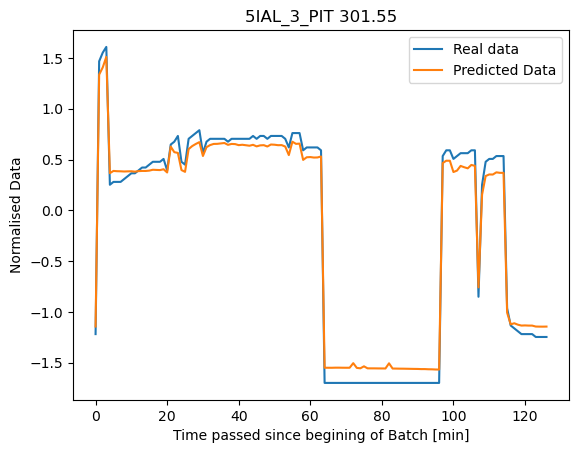

In [15]:
Random_Batch=Train_Grouped.get_group(random.sample(Train_Batches,1)[0])

Random_Batch=Random_Batch.drop(['5IAL_3_301.BatchName'],axis=1)
Random_Batch=np.expand_dims(Random_Batch,axis=2)
Random_Batch=np.expand_dims(Random_Batch,axis=3)


Random_Batch_Pred= model.predict(Random_Batch)

var=2

plt.plot(Random_Batch[:,var,0,0])
plt.plot(Random_Batch_Pred[:,var,0,0])
plt.legend(['Real data','Predicted Data'])
plt.xlabel('Time passed since begining of Batch [min]')
plt.ylabel('Normalised Data')
plt.title(data_norm.columns[var])